# EXAMPLE 

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [3]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines


In [4]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
print(total_string_len)

string_len_to_remove = len("Data Examination")
print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
print(path)
path_processed_data = path + "Processed_data\\"
print(path_processed_data)

c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Data Examination
61
16
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\


# Trial on Day-ahead data

So what is going to happen is as follows:

0. Try to plot day-ahead price
1. Try fit a periodic spline on day-ahead data
2. Pick 5 spots on the day-ahead price and add noise to it. Then fit a periodic spline function to it afterwards

Open the real.csv file and the day-ahead

### Loading data

In [5]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.fillna(0)
spot = data["Spot"].to_numpy()
spot_reshape = np.reshape(spot, (24, 90+365),order ='F') # F to ensure the correct reshaping.
spot_reshaped_forecasted = spot_reshape[:,365:]
mean_spot_all_days_test = np.mean(spot_reshaped_forecasted,axis=1)
mean_spot_all_days_train = np.mean(spot_reshape[:,0:365],axis=1)
std_spot_all_days = np.std(spot_reshaped_forecasted,axis = 1)


print(np.shape(spot_reshape[:,365:]))


(24, 90)


## Deciding on the training data

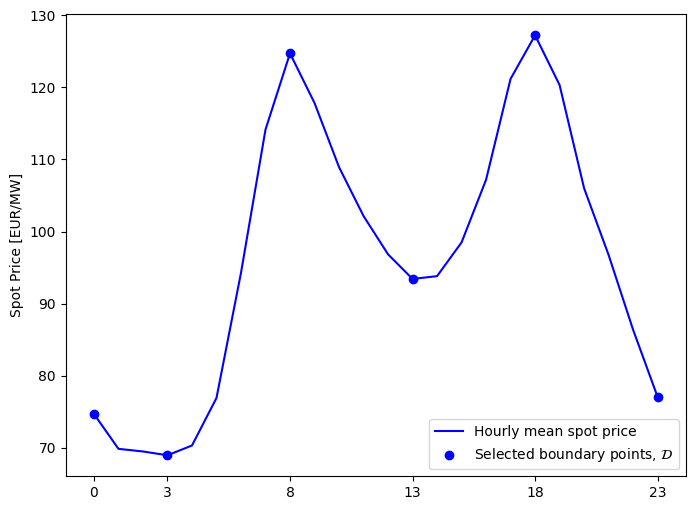

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=100)

x_train = np.array([0, 3, 8, 13, 18, 23])
y_train = mean_spot_all_days_test[x_train]

# Plot the data
plt.plot(mean_spot_all_days_test,c='blue', label='Hourly mean spot price')
plt.scatter(x_train, y_train, c='blue', label=r"Selected boundary points, $\mathcal{D}$")
plt.ylabel("Spot Price [EUR/MW]")

# Set the x-axis ticks
plt.xticks(x_train)
plt.legend()

# Show the plot
plt.savefig('Hourly_mean_test_periode.pdf', format="pdf", bbox_inches="tight")
plt.show()


# ADDING NOISE TO CREATE THE FORECASTS

First we assess the standard deviation of the time instances of our data, because then we know how much noise we should add.


In [7]:
print(np.reshape(std_spot_all_days[x_train],(6,1)))

[[44.59919174]
 [44.33765783]
 [59.98360161]
 [45.64464177]
 [55.60187293]
 [44.49921285]]


However the standard deviation is way too much, so let us take a percentage of it. For

- D-2, 30 %
- DA, 20 %
- D-1, 10 %

In [8]:
std_train = std_spot_all_days[x_train]*0.1
noise = np.random.normal(0, std_train, std_train.shape)
print(np.shape(noise))
print(noise)

(6,)
[-0.98409341 -0.39314605  1.48371969  8.7545164  -2.96504865  2.95819205]


In [5]:
def Forecast_of_spot(Spot_data, x_train_lst = [0,3,8,13,18,23], std_factor_increase = 0.1,deg = 3):

    '''
    Spot_data (dataframe). NEED TO BE DIVISIBLE OF 24
    x_train (list) [0,3,8,13,18,23]
    std_factor_increase (float) factor to multiply on the total standard deviation of the data
    '''

    # Load the data
    spot = Spot_data.to_numpy() # Transform to numpy
    spot_reshape = np.reshape(spot, (24, int(len(spot)/24)),order ='F') # F to ensure the correct reshaping
    mean_spot_all_days = np.mean(spot_reshape,axis=1)
    std_spot_all_days  = np.std(spot_reshape  ,axis = 1)

    # Set the training data settings
    x_train = np.array(x_train_lst) # Data which is traded upon
    X_train = x_train[:, np.newaxis] # necessary for the scikit method to work

    # Construct the noise
    std_train = std_spot_all_days[x_train]*0.2
    noise = np.random.normal(0, std_train, std_train.shape)

    # Set up the calculated parts
    True_Spot= spot_reshape 
    Forecast_no_noise = np.zeros((24,90))
    Forecast = np.zeros((24,90))


 
   # Set up settings for the Spline interpolation
    x_day = np.arange(24) # For plotting purposes
    X_day = x_day[:, np.newaxis]

    model = make_pipeline(SplineTransformer(n_knots=len(x_train_lst), degree=deg), Ridge(alpha=1e-3))

    days = len(True_Spot[0,:])
    for d in range(0,days):

        # Forecast with noise Two days prior
        y_train = True_Spot[x_train,d] + noise
        model.fit(X_train, y_train) 
        y_day = model.predict(X_day) 
        Forecast[:,d] = np.reshape(y_day, (24,) ) # Save the forecast

        # Forecast wit
        # Forecast without noise
        model.fit(X_train, spot_reshape[x_train,d]) 
        y_day = model.predict(X_day)
        Forecast_no_noise[:,d] = np.reshape(y_day, (24,) ) # Save the forecast


    
    return Forecast, Forecast_no_noise, True_Spot

In [11]:
# Array with 10 forecasts with different noise
Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
# Set up an 3D array of same length as spot_reshaped_forecasted and for different forecast versions
All_spot_forecasts = np.zeros((np.size(spot_reshaped_forecasted,0),np.size(spot_reshaped_forecasted,1),np.size(Noise_factor)))
print(np.shape(All_spot_forecasts))
for n,factor in enumerate(Noise_factor):
    Forecast, Forecast_no_noise, True_Spot = Forecast_of_spot(data["Spot"].loc[(24*365):],std_factor_increase=factor,deg=3)
    print(np.shape(Forecast))
    All_spot_forecasts[:,:,n] = Forecast

    # 


(24, 90, 6)
(24, 90)
(24, 90)
(24, 90)
(24, 90)
(24, 90)
(24, 90)


Visualize the forecasts

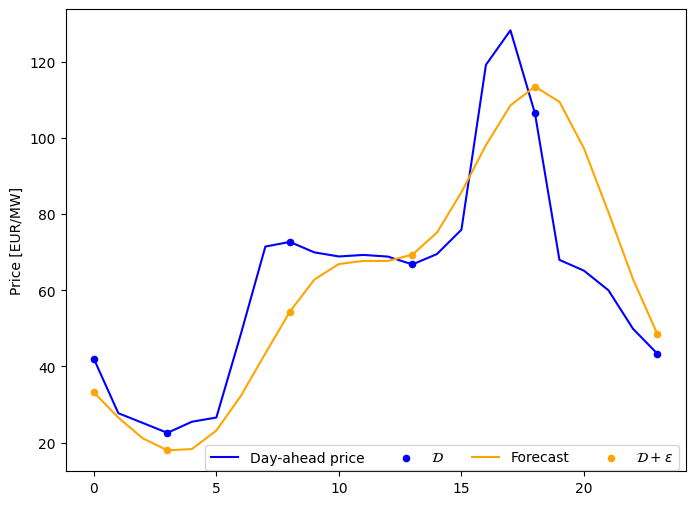

In [12]:
# Set the font size of the plot
plt.rcParams.update({'font.size': 10})

# Set the figure size and dpi
fig = plt.figure(figsize=(8, 6), dpi=100)

# Plot the data
d = 10
plt.plot(True_Spot[:,d],  label="Day-ahead price",  c='blue')
plt.scatter(x_train,True_Spot[x_train,d],  c='blue', s=20,label=r"$\mathcal{D}$")
Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
Noise_name = [""]

for n,name in enumerate(Noise_name):
    legend_Name = "Forecast"+name
    plt.plot(All_spot_forecasts[:,d,n],  label=legend_Name, c='orange')
    plt.scatter(x_train, All_spot_forecasts[x_train,d,n], c='orange', s=20,label=r"$\mathcal{D} + \epsilon$")

# Add a legend outside of the plots
fig.legend(loc="lower right",bbox_to_anchor = (0.9,0.1),ncol=4)

plt.ylabel("Price [EUR/MW]")


# Show the plot
plt.savefig('Spline_interpolation_example.pdf', format="pdf", bbox_inches="tight")
plt.show()


To get above result use this website and get how it calculate it: https://tools.timodenk.com/cubic-spline-interpolation

0 37.23
3 30.24
8 69.13
13 70.56
18 95.16
23 40.45

## Summary statistics of the forecast errors

In [20]:
Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
Forecast_number = [1, 2, 3, 4, 5, 6]
for n in range(0,np.size(All_spot_forecasts[:,:,:],2)):
    errors = (True_Spot.flatten() - All_spot_forecasts[:,:,n].flatten())

    MAPE_h = np.abs( (True_Spot.flatten() - All_spot_forecasts[:,:,n].flatten()) / (True_Spot.flatten()) ) * 100
    
    MAPE = np.mean(MAPE_h)
    Median_APE = np.median(MAPE_h)
    Std_APE = np.std(MAPE_h)

    
    df_describe = pd.DataFrame(MAPE_h)
    print("         ", "Noise factor", "    Mean    ","        Median        ", "      Std      ")
    print("Forecast-", Forecast_number[n], " ", Noise_factor[n]," ", MAPE, " ", Median_APE, " ", Std_APE)
    print()
    #print(df_describe.describe())
    #print(np.shape(MAPE_h))
    #print(MAPE)
    


          Noise factor     Mean             Median               Std      
Forecast- 1   0.1   42.03651924474782   10.141037521742366   415.8707410401416

          Noise factor     Mean             Median               Std      
Forecast- 2   0.5   39.32160656685089   11.69171284922446   346.20442742690227

          Noise factor     Mean             Median               Std      
Forecast- 3   1   45.00830461501203   8.418354595119006   581.9650879531869

          Noise factor     Mean             Median               Std      
Forecast- 4   2   52.21407865342151   12.874561725298857   597.2000880594264

          Noise factor     Mean             Median               Std      
Forecast- 5   4   29.233606338993958   9.836965179078938   207.48272202586514

          Noise factor     Mean             Median               Std      
Forecast- 6   8   74.82108378718041   8.914487247424125   1089.426623761852



Save it all into one dataframe:

In [33]:
True_Spot_reshaped = pd.DataFrame(np.reshape(True_Spot, (24*90,), order = 'F'),columns=["Spot"])

Forecast_reshaped = pd.DataFrame(np.reshape(Forecast, (24*90,), order = 'F'),columns=["Spot_forecast"])

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [6]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.fillna(0) 
data_cop = data.copy()
data = data.drop(columns=["Hour"])
setup_forecast = data_cop.drop(columns=["Hour"])
True_data = data.loc[8760:].reset_index(drop=True)
True_data_arr = True_data.to_numpy()
Spot_data = True_data['Spot']


In [100]:
Forecast_number = [1, 2, 3, 4, 5, 6]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Noise_factor = [0, 0.1, 0.5, 1, 1.5, 2]
Total_length_test = len(data["FD1_down"]) - 8760

# Create an empty dataframe with the same columns as `data`
print(Total_length_test,len(Forecasts),len(Forecast_number))
forecasted_data_3D = np.zeros(( Total_length_test, len(Forecasts), len(Forecast_number) ))  # (Specific Forecasts, Data size, number of total forecasts )

print(np.shape(forecasted_data_3D))

2160 11 6
(2160, 11, 6)


In [102]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")
std_col = np.std(data.loc[:, :],axis=0)
D_2_list = 24*[3,4,5,6,7]

for col in data.columns:
    index = Forecasts.index(col) # Get the index

    for n, noise in enumerate(Noise_factor): # For each noise factor / forecast
    
        if col == "Spot":
            # Run spline procedure
            # Use True_data

            Forecast_Spot, Forecast_Spot_no_noise, True_Spot = Forecast_of_spot(Spot_data,std_factor_increase=noise)
            Forecast_Spot_reshaped = np.reshape(Forecast_Spot, (24*90,), order = 'F')
            forecasted_data_3D[:,index,n] = Forecast_Spot_reshaped

            
        else: 
            # Run mean procedure

            # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
            if 'percentage' in col:
                    if "FD2" in col:
                        if "up" in col:
                            forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_up_percentage,n]
                        else:
                            forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_down_percentage,n]
                            #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
            else:
                for h in range(0,Total_length_test):
                    
                    forecasted_data_3D[h,index,n] = np.mean([data.loc[h+8760-hd, col] + std_col[col]*noise for hd in D_2_list])


    
        #True_data.loc[h, col] = data.loc[h+8760,col]
        #True_reshaped = np.reshape(True_data, (24*90,len(Forecasts)), order = 'F')
        #True_data[index, :] = True_Spot_reshaped # Populate the true data 
        
    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [103]:
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

        errors = (True_data_arr[:,f] - forecasted_data_3D[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    


        
        #df_describe = pd.DataFrame(MAPE_h)
        #print("         ", "Noise factor", " Feature","    Mean    ","        Median        ", "      Std      ")
        #print("Forecast-", Forecast_number[n], "-", Noise_factor[n],"    ",F[f],"   ", np.round(MAE), " ", np.round(Median_AE), " ", np.round(Std_AE))
        #print()
            
        # Save the proper data
        Saved_Info[n,f,0] = n 
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast  0      Spot ( 10.0 7.0 10.0 )     FD1_down ( 31.0 4.0 98.0 )     FD2_down ( 5.0 2.0 10.0 )     FD1_up ( 11.0 6.0 18.0 )     FD2_up ( 1.0 0.0 1.0 )
Forecast  1      Spot ( 11.0 8.0 10.0 )     FD1_down ( 36.0 11.0 97.0 )     FD2_down ( 6.0 3.0 9.0 )     FD1_up ( 13.0 8.0 17.0 )     FD2_up ( 3.0 3.0 1.0 )
Forecast  2      Spot ( 10.0 8.0 10.0 )     FD1_down ( 64.0 45.0 92.0 )     FD2_down ( 13.0 12.0 9.0 )     FD1_up ( 31.0 29.0 18.0 )     FD2_up ( 17.0 17.0 1.0 )
Forecast  3      Spot ( 12.0 10.0 10.0 )     FD1_down ( 104.0 90.0 88.0 )     FD2_down ( 24.0 24.0 9.0 )     FD1_up ( 59.0 59.0 19.0 )     FD2_up ( 33.0 33.0 1.0 )
Forecast  4      Spot ( 10.0 5.0 11.0 )     FD1_down ( 146.0 134.0 85.0 )     FD2_down ( 36.0 35.0 9.0 )     FD1_up ( 88.0 88.0 19.0 )     FD2_up ( 50.0 50.0 1.0 )
Forecast  5      Spot ( 10.0 7.0 11.0 )     FD1_down ( 188.0 179.0 84.0 )     FD2_down ( 47.0 47.0 9.0 )     FD1_up ( 117.0 117.0 20.0 )     FD2_up ( 66.0 66.0 1.0 )


## plotting the error

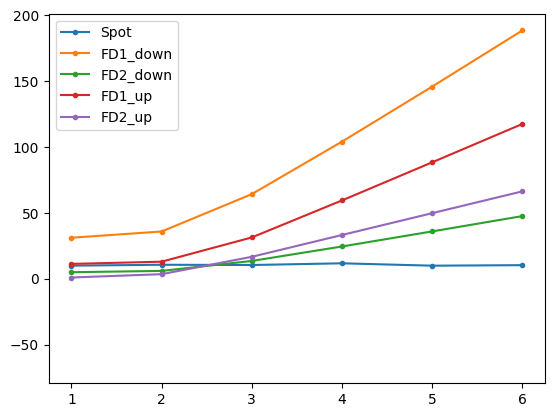

In [110]:
x = np.array(Forecast_number)

# plot for each feature
for f in range(0,F_len-6):
    
    MAE_f = Saved_Info[:,f,1]
    std_f = Saved_Info[:,f,3]
    plt.plot(x, MAE_f, label=F[f], marker='.')
    plt.fill_between(x, MAE_f-std_f, MAE_f-std_f, alpha=0.2)

plt.legend()
plt.show()

## Plot the hourly mean method

In [79]:
h = 0
d = 3
col = 'FD1_down'
idx_col = np.where(np.array(Forecasts) == col)[0]
print(idx_col[0])
scatter_points_mean = [0*24,1*24,2*24,3*24,4*24]
forecasting_time = [5*24]
D_2_list = [3,4,5,6,7]
start_true_train = (24+h)+(8760)-(D_2_list[-1]*24) + (d*24) - 1
end_true_train = (8760 + d*24) - 24
start_true_not_used = end_true_train + 1
end_true_not_used = start_true_not_used + 24 - 1
start_true_test = end_true_not_used + 1
end_true_test = start_true_test + 24 - 1
print(start_true_train , ":", end_true_train)
print(start_true_not_used , ":", end_true_not_used)
print(start_true_test , ":", end_true_test)


# Define the x axis
total_train_points = end_true_train-start_true_train
x_train_lst = list(range(0, total_train_points  ))
x_not_used_lst = list(range(total_train_points, total_train_points+24  ))
x_test_lst = list(range(total_train_points+24, total_train_points+48  ))


# Define the data used for the plo
plot_train_data = data[col].loc[start_true_train:end_true_train].reset_index(drop=True).to_frame()
plot_not_used_data = data[col].loc[start_true_not_used:end_true_not_used].reset_index(drop=True).to_frame()
plot_true_data = data[col].loc[start_true_test:end_true_test].reset_index(drop=True).to_frame()
plot_forecasted_data = pd.DataFrame(forecasted_data_3D[idx_col[0],h:(24+h),0])

# Define the scatter plots
mean_points = plot_train_data.loc[scatter_points_mean*24]
#combine_index = plot_data.index.size()

# Define the x axis for the different plots

x_train_axis = pd.DataFrame(x_train_lst)
x_not_used_axis = pd.DataFrame(x_not_used_lst)
x_test_axis = pd.DataFrame(x_test_lst)

plot_forecasted_data = plot_forecasted_data.set_index([pd.Index(x_test_lst)])
plot_true_data = plot_true_data.set_index([pd.Index(x_test_lst)])
plot_not_used_data = plot_not_used_data.set_index([pd.Index(x_not_used_lst)])




1
8687 : 8808
8809 : 8832
8833 : 8856


In [82]:
x_list = x_train_axis.loc[scatter_points_mean].values.tolist()
y_list = plot_train_data.loc[scatter_points_mean].values.tolist()
text_list = [r'$\lambda^{\mathrm{D-7}}_{1}$', r"$\lambda^{\mathrm{D-6}}_{1}$", r"$\lambda^{\mathrm{D-5}}_{1}$", r"$\lambda^{\mathrm{D-4}}_{1}$", r"$\lambda^{\mathrm{D-3}}_{1}$"]

c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a Type

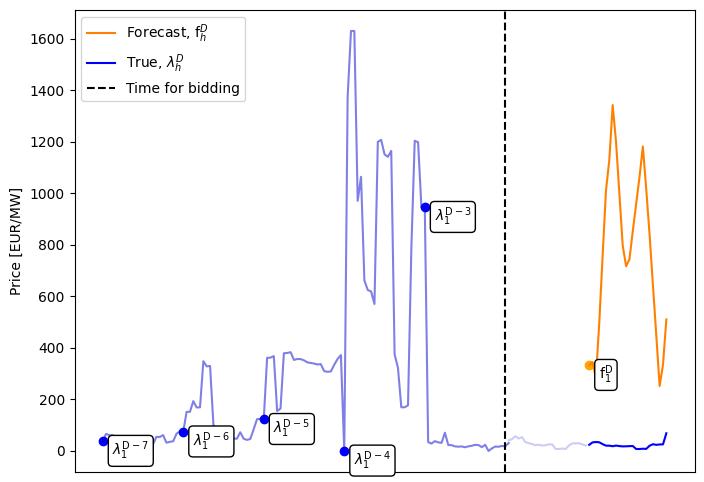

In [83]:
# Define RGB values for different shades of blue
blue_shades = [
    (0, 0, 1),        # Pure blue
    (0.4, 0.4, 1),    # Lighter blue
    (0, 0, 0.8),      # Darker blue
]

orange_shades = [
    (1, 0.5, 0),       # Pure orange
    (1, 0.7, 0.2),     # Lighter orange
    (0.8, 0.4, 0),     # Darker orange
]

# Set the figure size and dpi
fig = plt.figure(figsize=(8, 6), dpi=100)

plt.plot(plot_train_data,c=blue_shades[2],alpha=0.5)
plt.plot(plot_forecasted_data, label=r"Forecast, f$^{D}_h$",c=orange_shades[0])
plt.plot(plot_not_used_data,c=blue_shades[2],alpha=0.2)
plt.plot(plot_true_data, label="True, $\lambda^{D}_h$", c="blue")

# only one line may be specified; full height
plt.axvline(x=forecasting_time, color='black', linestyle='--',label= "Time for bidding")

# Scatter plot with custom text annotations and boxes
for x, y, text in zip(x_list, y_list, text_list):
    #print(x,y,text)
    plt.scatter(x[0],y[0],c="blue")
    plt.annotate(text, (x[0],y[0]), xytext=(7, -10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.scatter(x_test_axis.iloc[0], plot_forecasted_data.iloc[0],c="orange")
plt.annotate(r"f$^{\mathrm{D}}_{1}$", (x_test_axis.iloc[0],plot_forecasted_data.iloc[0]), xytext=(7, -10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))
# Remove x-axis tick marks and labels
plt.xticks([])

# Add a legend outside of the plots
plt.legend(loc="upper left")

plt.ylabel("Price [EUR/MW]")

# Show the plot
plt.savefig('Hourly_mean_forecast.pdf', format="pdf", bbox_inches="tight")
plt.show()


# Create a csv file for forecasted values of D-2

In [99]:

Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2)
F_len = np.size(forecasted_data_3D[:,:,:],0)
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    # change forecasted_data_3D to a dataframe
    df_forecast = pd.DataFrame(forecasted_data_3D[:,:,n], columns=F)
    
    #Create csv
    csv_name_path = path_processed_data+"forecast"+str(Forecast_number[n])+".csv"
    df_forecast.to_csv(csv_name_path,index=False)